In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data
import datetime as dt
import pandas_datareader.data as web
import time

## Importazione dati

In [2]:
def import_data(name,source='yahoo'):    
    start = dt.datetime(2009, 1, 1, 0, 0)
    end = dt.datetime.now()
    df = web.DataReader(name, source, start, end)
    #Symbol = 'High'
    df.reset_index(inplace=True)
    df.set_index("Date", inplace=True)
    df = df.drop(['Low','Open','Adj Close','High','Volume'],axis='columns')
    return df

In [3]:
# QUI VENGONO IMPORTATO GLI ETF, SPECIFICANDO IL LORO TICKER.
# IN QUESTO ESEMPIO 1) AZIONARIO GLOBALE, 2) AZIONARIO EMERGENTI, 3) BOND EUROPEI, 4) BOND SOCIETARI, 5) ORO
# PUOI CAMBIARE ETF CAMBIANDO I TICKERS, DOPO IMPORT_DATA


df=import_data(['IWDE.MI','IEEM.MI','XGLE.MI','IBCX.MI','XAD1.MI']) 
#df=import_data(['SWDA.MI','IEEM.MI','IEAG.MI','IBCX.MI','XAD1.MI'])
df.columns=['Msci','Emergenti','EUBond','CorporateBond','Gold']

df=df.fillna(method='ffill')

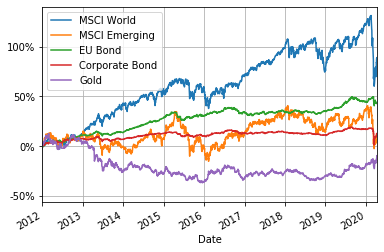

In [4]:
# NORMALIZZAZIONE AL SOLO FINE ILLUSTRATIVO

normalizzazione_ETF=np.array(df[df.index=='2012-01-02'])

dfnorm=df/normalizzazione_ETF

dfnorm.plot()
plt.xlim('2012','2020-04-15')
plt.grid()
plt.legend(['MSCI World','MSCI Emerging','EU Bond','Corporate Bond','Gold'])
plt.yticks([0.5,1,1.5,2],['-50%','0%','50%','100%'])
plt.savefig('output_portfolio/grafico_etf.png',dpi=300)
plt.show()

## Definizione delle funzioni principali

### massimo drawdown

8.848654901726306 93


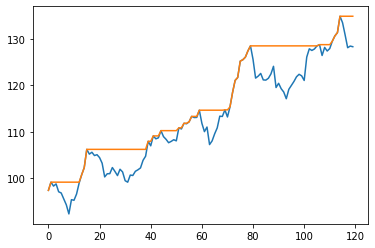

In [5]:
# DEFINIZIONE DELLA FUNZIONE PER IL CALCOLO DEL MASSIMO DRAWDOWN

rand_sequence=np.random.normal(3/12,5/np.sqrt(12),size=12*10)
rend_cumulativo=np.cumprod(1+rand_sequence/100)*100


def drawdown(array):
    massimo=array[0]
    lista=[]
    for i in range(len(array)):
        if array[i]>massimo:
            massimo=array[i]
            lista.append(massimo)
        else:
            lista.append(massimo)
     
    lista=np.array(lista)
    
    drawdown_parz=(lista-array)/lista*100
    #print(np.max(drawdown_parz),np.argmax(drawdown_parz))
    
    return (np.max(drawdown_parz),np.argmax(drawdown_parz),lista)


massimo_esp=drawdown(rend_cumulativo)

print(massimo_esp[0],massimo_esp[1])

plt.plot(rend_cumulativo)
plt.plot(massimo_esp[2])
plt.show()

### simulazione portafoglio  (con ribilanciamento di default)

In [6]:
# SIMULAZIONE PORTAFOGLIO, CON RIBILANCIAMENTO ATTUALE

def rendimento_bis(ripartizione,capitale0=100000,inizio='2012',fine='2021',nomietf=['Msci','Emergenti','EUBond','CorporateBond','Gold'],ribilanciamento=True):
    
    # durata dell'investimento
    df2=df[(df.index>=inizio) & (df.index<=fine)]
    inizio_num=pd.to_numeric(str(inizio))
    durata=(df2.index[-1]-df2.index[0]).days/365
    anni_grid=np.arange(inizio_num,inizio_num+durata,1)
    
    # prezzi ad inizio anno
    titoli=[]
    for anni in anni_grid:
        titoli.append(df[str(int(anni))].iloc[1])
    titoli=np.array(titoli) 
    
    # capitale iniziale
    cap_iniziale=capitale0
    ripartizione=np.array(ripartizione)
    cap_rip=ripartizione/100*capitale0
    num_rip=cap_rip/titoli[0,:]
    
    # evoluzione del capitale
    if ribilanciamento==True:
        for i in range(len(titoli)):
            newcap=num_rip*titoli[i,:]
            capitale0=np.sum(newcap)
            cap_rip=ripartizione/100*capitale0
            num_rip=cap_rip/titoli[i,:]
            #print(i,capitale0,anni_grid[i])
    else:
        for i in range(len(titoli)):
            newcap=num_rip*titoli[i,:]
            capitale0=np.sum(newcap)
            #print(i,capitale0,anni_grid[i])
    
    # capitale finale
    prezzi_finali=np.array(df2.iloc[-1,:])
    cap_finale=np.sum(num_rip*prezzi_finali)
    #print(cap_finale)
        
    # rendimento
    rendimento_tot=round((cap_finale/cap_iniziale-1)*100,2)
    rendimento_ann=round(((cap_finale/cap_iniziale)**(1/durata)-1)*100,2)
    
    return rendimento_tot,rendimento_ann
    
rendimento_bis([45*2/3,45*1/3,50*2/3,50*1/3,5])

(50.81, 5.0)

## Analisi

### rendimenti nel 2020

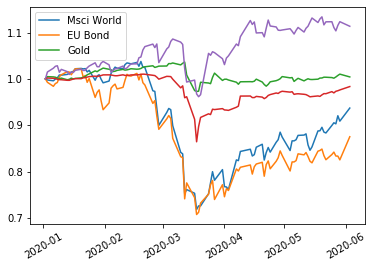

In [7]:
# rendimenti da inizio 2020

df_2020=df.loc[df.index>='2020-01-02',:]
df_2020=df_2020/df_2020.iloc[0,:]

rend_2020=(df_2020.iloc[-1,:]-df_2020.iloc[0,:])/df_2020.iloc[0,:]*100
rend_2020=rend_2020.values

plt.plot(df_2020)
plt.legend(['Msci World','EU Bond','Gold'])
#plt.xlim('2020-01-02','2020-05-28')
plt.xticks(rotation=30)
plt.show()

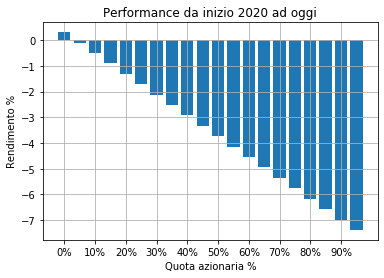

In [8]:
act_grid=np.arange(0,96,5)
y_oro5=[]

for act in act_grid:
    ob=100-act-5
    vec=np.array([act*2/3,act*1/3,ob*2/3,ob*1/3,5])
    #print(vec[0]+vec[1],vec[2]+vec[3],vec[4])
    rr=np.sum(rend_2020*vec/100)
    y_oro5.append(rr)

    
plt.bar(act_grid/5,y_oro5,label='No oro')
plt.xticks(np.arange(0,20,2),['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
#plt.legend()
plt.grid()
plt.xlabel('Quota azionaria %')
plt.ylabel('Rendimento %')
plt.title('Performance da inizio 2020 ad oggi')
plt.savefig('output_portfolio/portfoglio_2020.png',dpi=300)
plt.show()

### rendimento storico dal 2012

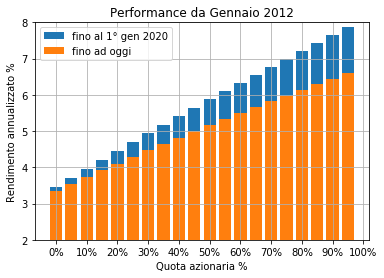

In [9]:
act_grid=np.arange(0,96,5)
y_oro5=[]
y_oro5_feb20=[]
#y_oro20=[]
#y_oro50=[]

for act in act_grid:
    ob=100-act-5
    vec=np.array([act*2/3,act*1/3,ob*2/3,ob*1/3,5])
    rr=rendimento_bis(vec,inizio='2012',fine='2020-07')[1]
    y_oro5.append(rr)
    
for act in act_grid:
    ob=100-act-5
    vec=np.array([act*2/3,act*1/3,ob*2/3,ob*1/3,5])
    rr=rendimento_bis(vec,inizio='2012',fine='2019-12-31')[1]
    y_oro5_feb20.append(rr)
    
#for act in act_grid:
#    rr=rendimento_bis([act*0.8,0,100-act,0,act*0.2],inizio='2012',fine='2020-06')[1]
#    y_oro20.append(rr)
    
#for act in act_grid:
#    rr=rendimento_bis([act*0.5,0,100-act,0,act*0.5],inizio='2012',fine='2020-06')[1]
#    y_oro50.append(rr)
 
plt.bar(act_grid/5,y_oro5_feb20,label='fino al 1° gen 2020')    
plt.bar(act_grid/5,y_oro5,label='fino ad oggi')
#plt.bar(act_grid/10,y_oro20,label='Oro = 20% della quota azionaria')
#plt.bar(act_grid/10,y_oro50,label='Oro = 50% della quota azionaria')
plt.xticks(np.arange(0,21,2),['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
plt.legend()
plt.grid()
plt.ylim(2,8)
plt.xlabel('Quota azionaria %')
plt.ylabel('Rendimento annualizzato %')
plt.title('Performance da Gennaio 2012')
plt.savefig('output_portfolio/portfoglio_2012.png',dpi=300)
plt.show()

In [10]:
from scipy.interpolate import interp1d

rend_atteso=interp1d(act_grid,y_oro5,fill_value='extrapolate',kind='linear')

### analisi della massima perdita nel 2020

In [11]:
def massima_perdita(vec):
    
    df_2020=df.loc[df.index>='2020-01-02',:]
    df_2020=np.array(df_2020/df_2020.iloc[0,:])
        
    andamento=np.sum(vec*df_2020,axis=1)
        
    return drawdown(andamento)[0]

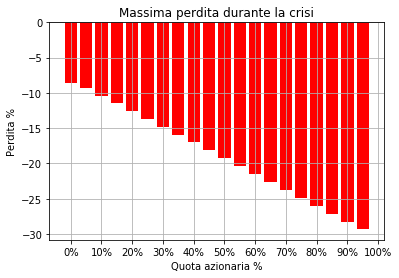

In [12]:
act_grid=np.arange(0,96,5)
y_oro5p=[]

for act in act_grid:
    ob=100-act-5
    vec=np.array([act*2/3,act*1/3,ob*2/3,ob*1/3,5])
    rr=massima_perdita(vec)
    y_oro5p.append(rr)

    
plt.bar(act_grid/5,-np.array(y_oro5p),label='No oro',color='red')
plt.xticks(np.arange(0,21,2),['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
#plt.legend()
plt.grid()
plt.xlabel('Quota azionaria %')
plt.ylabel('Perdita %')
plt.title('Massima perdita durante la crisi')
plt.savefig('output_portfolio/massima_perdita.png',dpi=300)
plt.show()

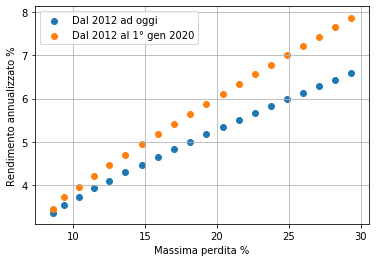

In [13]:
plt.scatter(y_oro5p,y_oro5,label='Dal 2012 ad oggi')
plt.scatter(y_oro5p,y_oro5_feb20,label='Dal 2012 al 1° gen 2020')
plt.xlabel('Massima perdita %')
plt.ylabel('Rendimento annualizzato %')
plt.grid()
plt.legend()
plt.savefig('output_portfolio/rischio_rendimento.png',dpi=300)
plt.show()

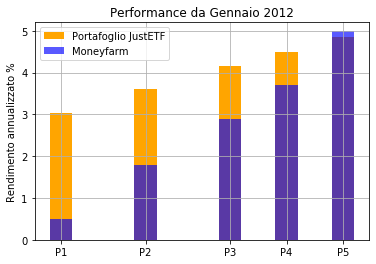

In [38]:
# confronto con Moneyfarm

act_grid=np.array([10,25,40,50,60])
act_grid=act_grid-5
y_oro5=[]


for act in act_grid:
    ob=100-act-5
    vec=np.array([act*2/3,act*1/3,ob*2/3,ob*1/3,5])
    rr=rendimento_bis(vec,inizio='2012',fine='2020-07')[1]
    y_oro5.append(rr)
    

plt.bar(act_grid/5,np.array(y_oro5)-0.5,label='Portafoglio JustETF',color='orange')
plt.bar(act_grid/5,np.array([1.4,2.7,3.8,4.6,5.9])-0.9,label='Moneyfarm',alpha=0.65,color='blue')
#plt.bar(act_grid/10,y_oro20,label='Oro = 20% della quota azionaria')
#plt.bar(act_grid/10,y_oro50,label='Oro = 50% della quota azionaria')
plt.xticks(act_grid/5,['P1','P2','P3','P4','P5'])
plt.legend()
plt.grid()
plt.ylim(0,5.2)
#plt.xlabel('Quota azionaria %')
plt.ylabel('Rendimento annualizzato %')
plt.title('Performance da Gennaio 2012')
plt.savefig('output_portfolio/portfoglio_moneyfarm_cfr.png',dpi=300)
plt.show()

## Calcolo dell'investimento consigliato

In [14]:
def invest_consigliato(patr_totale,da_investire,liv_rischio):    

    quota_a_rischio=liv_rischio/100*patr_totale
    
    quota_azionaria=round(patr_totale*2*liv_rischio/100/da_investire*100,1)
    
    if quota_azionaria>=100:
        quota_azionaria=100
    
    quota_obblig=100-quota_azionaria
    
    rend_exp=round(rend_atteso([quota_azionaria,100])[0],1)
    
    # output. Portafoglio (quota_a_rischio,quota_obblig con oro al 5%) , massima perdita stimata, rendimento atteso
    
    return quota_azionaria-5,quota_obblig,5,quota_a_rischio,rend_exp

In [43]:
invest_consigliato(15000+26000+19000,10000,5)

(55.0, 40.0, 5, 3000.0, 5.5)

In [16]:
### oppure investire in un portafoglio 50%-50%, che ha un rischio del 25%.
### Investendo il 20% del patrimonio, il rischio complessivo diventa del 5%. 

In [44]:
15000+26000+19000

60000